# CNN + MaxPool
Model was overfitting. 

Here, do away with the max pooling layer.

Observe even worse overfitting.

In [ ]:
from datetime import datetime
print(datetime.now())

2023-03-21 16:22:19.610128


In [ ]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [ ]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [ ]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [ ]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [ ]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [ ]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    #pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    #drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    #cnn.add(cnn2_layer)
    #cnn.add(pool1_layer)
    #cnn.add(cnn3_layer)
    #cnn.add(cnn4_layer)
    #cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    #cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [ ]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-21 16:22:20.909342
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_96 (Conv1D)          (None, 4990, 64)          2112      
                                                                 
 flatten_24 (Flatten)        (None, 319360)            0         
                                                                 
 dense_24 (Dense)            (None, 1)                 319361    
                                                                 
Total params: 322,501
Trainable params: 322,501
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [ ]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [ ]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-21 16:22:21.067862
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-21 16:22:29.196803

Training # 1 1
2023-03-21 16:22:29.197695
2023-03-21 16:22:29.206348
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-21 16:22:30.455979


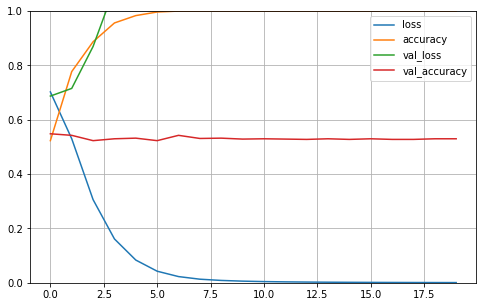


2023-03-21 16:22:50.450693

Testing # 1 1
2023-03-21 16:22:50.452051
2023-03-21 16:22:50.452376
PREDICT
2023-03-21 16:22:50.915053
Test 1:0 458:412 52.64%
Predict 1:0 483:387 55.52%
Test sizes (870, 4997) (870,)
Range of scores: 3.0488233e-11 to 1.0
Score threshold 0.5
Confusion matrix
 [[195 217]
 [192 266]]
Normalized matrix
 [[0.22413793 0.24942529]
 [0.22068966 0.30574713]]


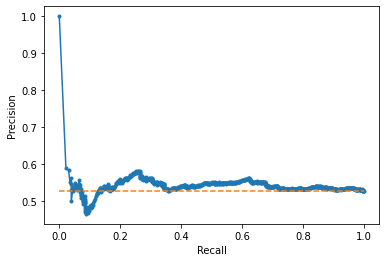

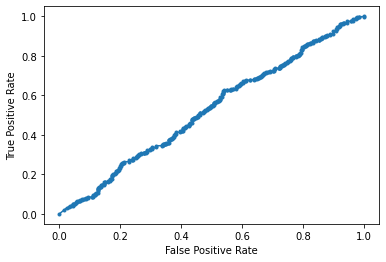

Accuracy: 52.99% Precision: 55.07% Recall: 58.08%
F1: 56.54% MCC: 0.0543
AUPRC: 54.64% AUROC: 52.69%
 accuracy [52.98850574712644]
 precision [55.072463768115945]
 recall [58.07860262008734]
 F1 [56.5356004250797]
 MCC [0.05434319509763149]
 AUPRC [54.64251798408396]
 AUROC [52.693485818459315]
2023-03-21 16:22:51.781217

Training # 1 2
2023-03-21 16:22:51.783768
2023-03-21 16:22:51.783821
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-21 16:22:53.434563


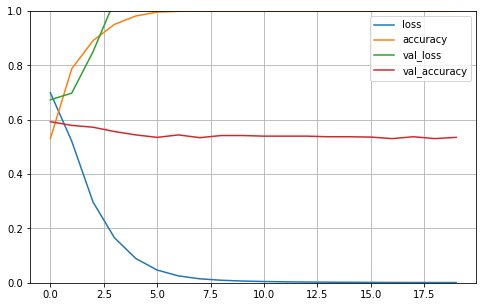


2023-03-21 16:23:12.030774

Testing # 1 2
2023-03-21 16:23:12.030868
2023-03-21 16:23:12.030906
PREDICT
2023-03-21 16:23:12.263393
Test 1:0 442:442 50.00%
Predict 1:0 483:401 54.64%
Test sizes (884, 4997) (884,)
Range of scores: 1.4101536e-11 to 1.0
Score threshold 0.5
Confusion matrix
 [[216 226]
 [185 257]]
Normalized matrix
 [[0.24434389 0.25565611]
 [0.20927602 0.29072398]]


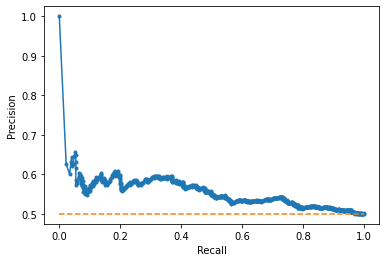

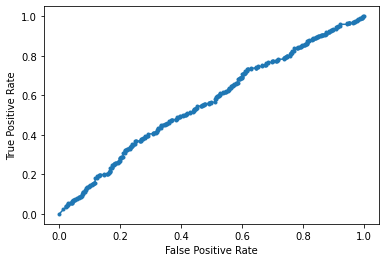

Accuracy: 53.51% Precision: 53.21% Recall: 58.14%
F1: 55.57% MCC: 0.0704
AUPRC: 55.85% AUROC: 56.51%
 accuracy [53.50678733031674]
 precision [53.20910973084886]
 recall [58.144796380090504]
 F1 [55.567567567567565]
 MCC [0.07043944770746292]
 AUPRC [55.84789873717846]
 AUROC [56.51450625499068]
2023-03-21 16:23:12.905706

Training # 1 3
2023-03-21 16:23:12.905845
2023-03-21 16:23:12.905889
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-21 16:23:14.143030


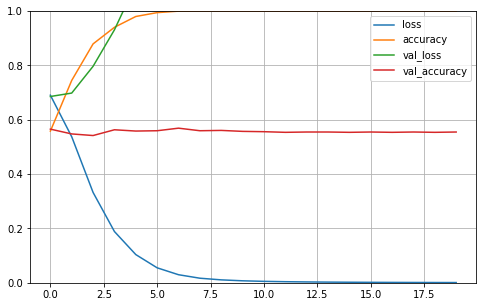


2023-03-21 16:23:32.865062

Testing # 1 3
2023-03-21 16:23:32.866849
2023-03-21 16:23:32.867270
PREDICT
2023-03-21 16:23:33.161761
Test 1:0 442:407 52.06%
Predict 1:0 436:413 51.35%
Test sizes (849, 4997) (849,)
Range of scores: 9.783633e-10 to 1.0
Score threshold 0.5
Confusion matrix
 [[221 186]
 [192 250]]
Normalized matrix
 [[0.26030624 0.21908127]
 [0.22614841 0.29446408]]


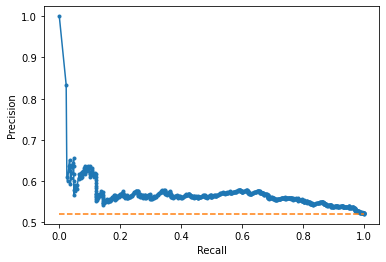

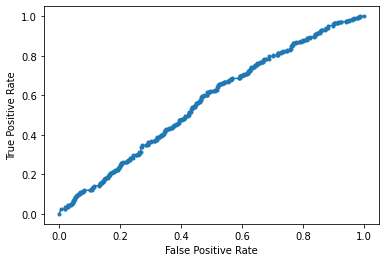

Accuracy: 55.48% Precision: 57.34% Recall: 56.56%
F1: 56.95% MCC: 0.1086
AUPRC: 57.33% AUROC: 56.70%
 accuracy [55.47703180212014]
 precision [57.3394495412844]
 recall [56.56108597285068]
 F1 [56.947608200455576]
 MCC [0.10855591580571954]
 AUPRC [57.328340774196754]
 AUROC [56.703391997509634]
2023-03-21 16:23:33.719259

Training # 1 4
2023-03-21 16:23:33.720417
2023-03-21 16:23:33.720474
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-21 16:23:34.952916


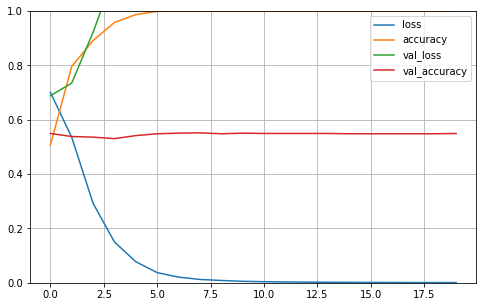


2023-03-21 16:23:56.812913

Testing # 1 4
2023-03-21 16:23:56.815583
2023-03-21 16:23:56.815940
PREDICT
2023-03-21 16:23:57.542107
Test 1:0 459:431 51.57%
Predict 1:0 488:402 54.83%
Test sizes (890, 4997) (890,)
Range of scores: 1.7895595e-09 to 1.0
Score threshold 0.5
Confusion matrix
 [[216 215]
 [186 273]]
Normalized matrix
 [[0.24269663 0.24157303]
 [0.20898876 0.30674157]]


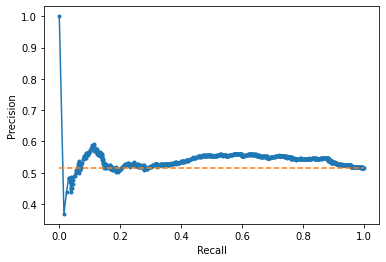

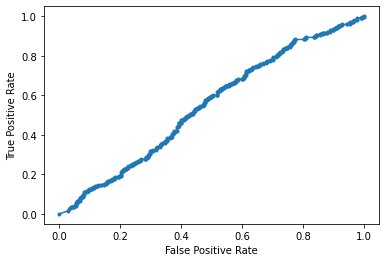

Accuracy: 54.94% Precision: 55.94% Recall: 59.48%
F1: 57.66% MCC: 0.0963
AUPRC: 53.91% AUROC: 54.72%
 accuracy [54.9438202247191]
 precision [55.942622950819676]
 recall [59.47712418300654]
 F1 [57.655755015839496]
 MCC [0.09633465067690722]
 AUPRC [53.91007093296535]
 AUROC [54.723271107875995]
2023-03-21 16:23:58.937087

Training # 1 5
2023-03-21 16:23:58.937289
2023-03-21 16:23:58.937370
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-21 16:24:03.143099


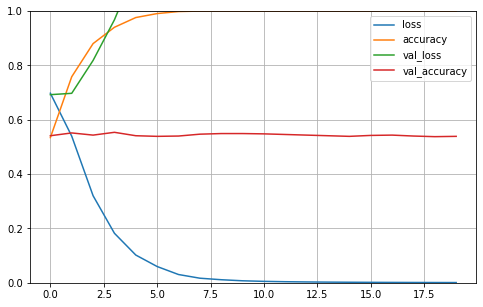


2023-03-21 16:24:21.994458

Testing # 1 5
2023-03-21 16:24:21.994575
2023-03-21 16:24:21.994612
PREDICT
2023-03-21 16:24:22.226426
Test 1:0 457:419 52.17%
Predict 1:0 479:397 54.68%
Test sizes (876, 4997) (876,)
Range of scores: 6.4899856e-11 to 1.0
Score threshold 0.5
Confusion matrix
 [[206 213]
 [191 266]]
Normalized matrix
 [[0.23515982 0.24315068]
 [0.21803653 0.30365297]]


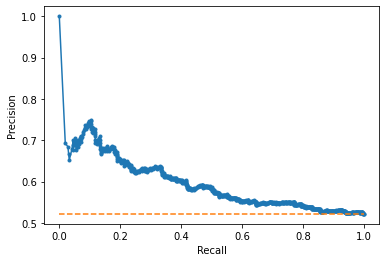

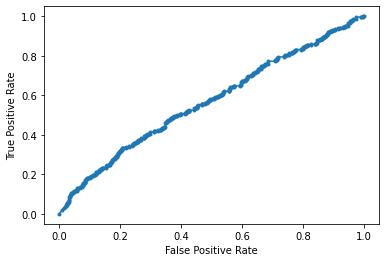

Accuracy: 53.88% Precision: 55.53% Recall: 58.21%
F1: 56.84% MCC: 0.0740
AUPRC: 59.78% AUROC: 56.98%
 accuracy [53.88127853881278]
 precision [55.53235908141963]
 recall [58.20568927789934]
 F1 [56.837606837606835]
 MCC [0.07395903227079408]
 AUPRC [59.77922397409519]
 AUROC [56.9810374811341]
2023-03-21 16:24:22.819460

Training # 2 1
2023-03-21 16:24:22.819814
2023-03-21 16:24:22.819855
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-21 16:24:24.043998


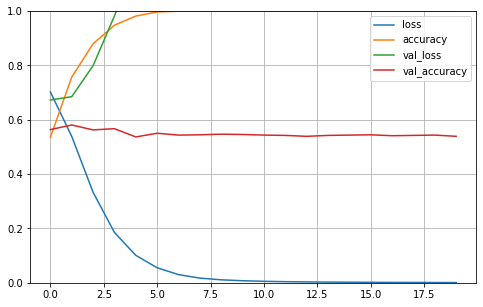


2023-03-21 16:24:43.370195

Testing # 2 1
2023-03-21 16:24:43.370287
2023-03-21 16:24:43.370332
PREDICT
2023-03-21 16:24:43.599576
Test 1:0 472:415 53.21%
Predict 1:0 489:398 55.13%
Test sizes (887, 4997) (887,)
Range of scores: 7.736088e-12 to 1.0
Score threshold 0.5
Confusion matrix
 [[202 213]
 [196 276]]
Normalized matrix
 [[0.22773393 0.24013529]
 [0.22096956 0.31116122]]


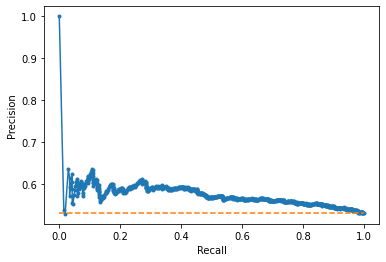

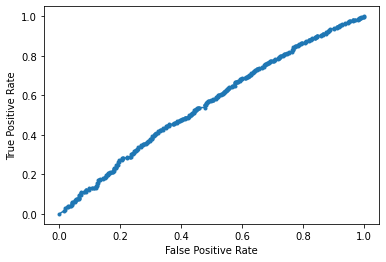

Accuracy: 53.89% Precision: 56.44% Recall: 58.47%
F1: 57.44% MCC: 0.0717
AUPRC: 57.58% AUROC: 55.75%
 accuracy [53.88951521984217]
 precision [56.44171779141104]
 recall [58.47457627118644]
 F1 [57.4401664932362]
 MCC [0.07172343633325377]
 AUPRC [57.58340290060329]
 AUROC [55.75301204819277]
2023-03-21 16:24:44.270081

Training # 2 2
2023-03-21 16:24:44.270224
2023-03-21 16:24:44.270270
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-21 16:24:45.526938


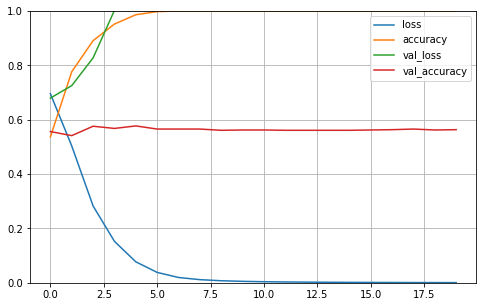


2023-03-21 16:25:04.259314

Testing # 2 2
2023-03-21 16:25:04.259432
2023-03-21 16:25:04.259471
PREDICT
2023-03-21 16:25:04.490572
Test 1:0 452:416 52.07%
Predict 1:0 461:407 53.11%
Test sizes (868, 4997) (868,)
Range of scores: 3.382152e-10 to 1.0
Score threshold 0.5
Confusion matrix
 [[222 194]
 [185 267]]
Normalized matrix
 [[0.25576037 0.2235023 ]
 [0.21313364 0.30760369]]


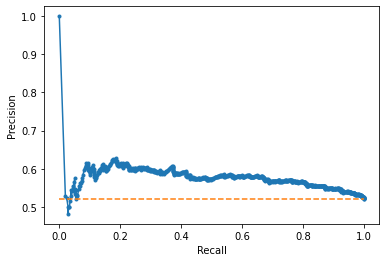

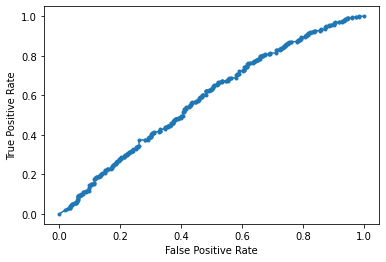

Accuracy: 56.34% Precision: 57.92% Recall: 59.07%
F1: 58.49% MCC: 0.1245
AUPRC: 57.91% AUROC: 58.52%
 accuracy [56.336405529953915]
 precision [57.9175704989154]
 recall [59.070796460176986]
 F1 [58.48849945235487]
 MCC [0.1244959582480668]
 AUPRC [57.91271154702824]
 AUROC [58.52275144656228]
2023-03-21 16:25:06.031054

Training # 2 3
2023-03-21 16:25:06.033611
2023-03-21 16:25:06.034729
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-21 16:25:08.343930


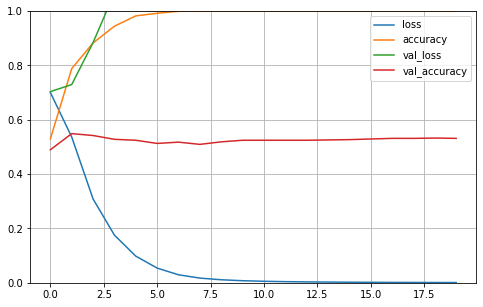


2023-03-21 16:25:27.158129

Testing # 2 3
2023-03-21 16:25:27.158216
2023-03-21 16:25:27.158250
PREDICT
2023-03-21 16:25:27.385915
Test 1:0 453:407 52.67%
Predict 1:0 480:380 55.81%
Test sizes (860, 4997) (860,)
Range of scores: 1.40204e-12 to 1.0
Score threshold 0.5
Confusion matrix
 [[192 215]
 [188 265]]
Normalized matrix
 [[0.22325581 0.25      ]
 [0.21860465 0.30813953]]


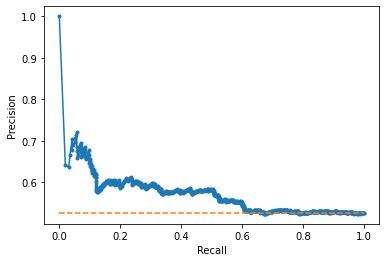

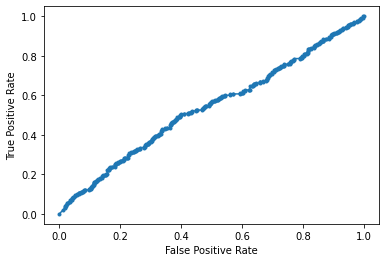

Accuracy: 53.14% Precision: 55.21% Recall: 58.50%
F1: 56.81% MCC: 0.0570
AUPRC: 57.41% AUROC: 53.79%
 accuracy [53.13953488372093]
 precision [55.208333333333336]
 recall [58.498896247240616]
 F1 [56.80600214362273]
 MCC [0.05703913908586355]
 AUPRC [57.40525652897167]
 AUROC [53.78530246079916]
2023-03-21 16:25:28.011172

Training # 2 4
2023-03-21 16:25:28.011312
2023-03-21 16:25:28.011370
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-21 16:25:29.218910


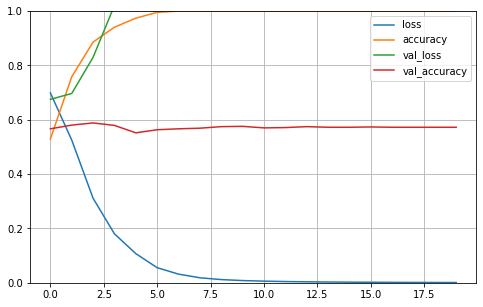


2023-03-21 16:25:50.188176

Testing # 2 4
2023-03-21 16:25:50.188609
2023-03-21 16:25:50.188645
PREDICT
2023-03-21 16:25:50.430799
Test 1:0 432:447 49.15%
Predict 1:0 476:403 54.15%
Test sizes (879, 4997) (879,)
Range of scores: 2.6454254e-11 to 1.0
Score threshold 0.5
Confusion matrix
 [[237 210]
 [166 266]]
Normalized matrix
 [[0.26962457 0.23890785]
 [0.18885097 0.30261661]]


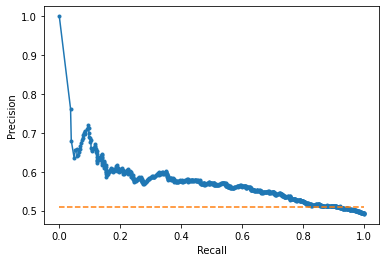

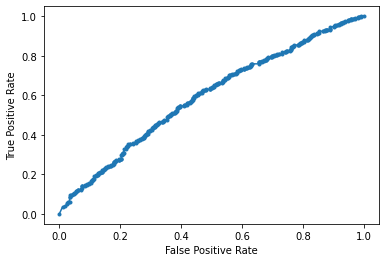

Accuracy: 57.22% Precision: 55.88% Recall: 61.57%
F1: 58.59% MCC: 0.1464
AUPRC: 57.96% AUROC: 59.27%
 accuracy [57.22411831626849]
 precision [55.88235294117647]
 recall [61.57407407407407]
 F1 [58.590308370044056]
 MCC [0.14642666672769564]
 AUPRC [57.96206337363393]
 AUROC [59.271946723009364]
2023-03-21 16:25:51.072015

Training # 2 5
2023-03-21 16:25:51.072136
2023-03-21 16:25:51.072171
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-21 16:25:52.299447


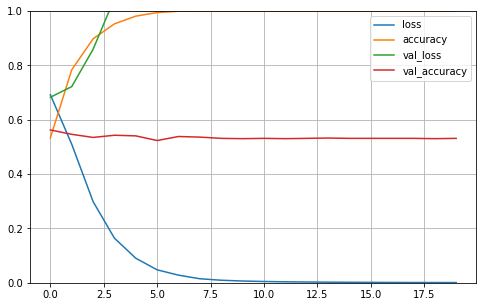


2023-03-21 16:26:14.028682

Testing # 2 5
2023-03-21 16:26:14.028759
2023-03-21 16:26:14.028790
PREDICT
2023-03-21 16:26:14.477579
Test 1:0 449:426 51.31%
Predict 1:0 481:394 54.97%
Test sizes (875, 4997) (875,)
Range of scores: 3.8458712e-11 to 1.0
Score threshold 0.5
Confusion matrix
 [[205 221]
 [189 260]]
Normalized matrix
 [[0.23428571 0.25257143]
 [0.216      0.29714286]]


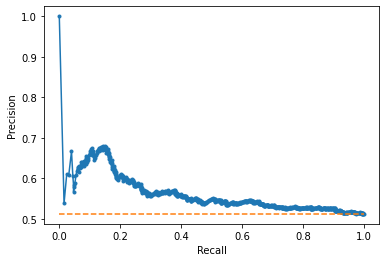

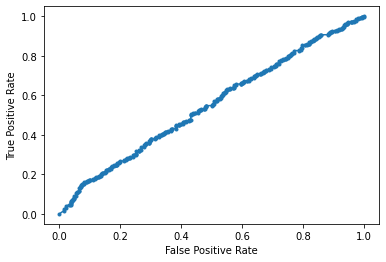

Accuracy: 53.14% Precision: 54.05% Recall: 57.91%
F1: 55.91% MCC: 0.0606
AUPRC: 56.45% AUROC: 54.94%
 accuracy [53.142857142857146]
 precision [54.054054054054056]
 recall [57.906458797327396]
 F1 [55.91397849462365]
 MCC [0.060564530234052436]
 AUPRC [56.44675256117257]
 AUROC [54.94055647918692]
2023-03-21 16:26:15.318376


In [ ]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [ ]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 54.45% std 1.48
 precision mean 55.66% std 1.41
 recall mean 58.60% std 1.30
 F1 mean 57.08% std 0.99
 MCC mean 0.09% std 0.03
 AUPRC mean 56.88% std 1.72
 AUROC mean 55.99% std 2.04
 accuracy [[52.98850574712644], [53.50678733031674], [55.47703180212014], [54.9438202247191], [53.88127853881278], [53.88951521984217], [56.336405529953915], [53.13953488372093], [57.22411831626849], [53.142857142857146]]
 precision [[55.072463768115945], [53.20910973084886], [57.3394495412844], [55.942622950819676], [55.53235908141963], [56.44171779141104], [57.9175704989154], [55.208333333333336], [55.88235294117647], [54.054054054054056]]
 recall [[58.07860262008734], [58.144796380090504], [56.56108597285068], [59.47712418300654], [58.20568927789934], [58.47457627118644], [59.070796460176986], [58.498896247240616], [61.57407407407407], [57.906458797327396]]
 F1 [[56.5356004250797], [55.567567567567565], [56.947608200455576], [57.655755015839496], [56.837606837606835], [57.4401664932362], 